In [362]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product


import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

%matplotlib inline

<b><h3>Statistical Machine Learning</h3></b>

Recent advances in statistics have been devoted to developing more powerful automated techniques for predictive modeling- both regression and classification. These methods, are supervised methods- they are trained on datat where outcomes are known and learn to predict outcomes in new data. They fall under the umbrella of statistical machine learning and are distinguished from classical statistical methods in that they are data-driven and do not seek to impose linear or other structure on the data. The K-Nearest Neighbors method, for example, is quite simple: classify a record in accordance with how similar records are classified. The most successful and widely used techniques are based on <em>ensemble learning</em> applied to <em>decision trees</em>.  The basic idea of ensemble learning is to use many models to form a prediction, as opposed to using just a single model. Decision trees are a flexible and automatic technique to learn rules about the relationships between predictor variables and outcome variables. It turns out that the combination of ensemble learning with decision trees leads to some of the best performing off-the-shelf predictive modeling techniques.

<b><h3>K-Nearest Neighbors</h3></b>

The idea behind K-Nearest Neighbors is very simple. For each record to be classified or predicted:
1. Find K records that have similar features (i.e., similar predictor values).
2. For classification, find out what the majority class is among these similar records and assign that class to the new record.
3. For prediction (also known as KNN regression), find the average among those similar records, and predict that average for the new record.

KNN is one of the simpler prediction / classification techniques: there is no model to be fit (as in regression). This doesn't mean that using KNN is an automatic procedure. The prediction rules depend on how the features are scaled, how similarity is measured, and how big K is set. Also, all predictors must be in numeric form (for similarity measure).

In [363]:
loan200 = pd.read_csv('../data/loan200.csv')
loan200.head()

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81


In [364]:
predictors= ['payment_inc_ratio', 'dti']
outcome = 'outcome'

newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X,y)
knn.predict(newloan)

array(['paid off'], dtype=object)

While the output of KNN for classification is typically a binary decision, such as default or paid off in the loan data, KNN routines usually offer the opportunity to output a probability (propensity) between 0 and 1. The probability is based on the fraction of one class in the K nearest neighbors. In the preceding example, the probability of default would have been $\dfrac{9}{20}$ or 0.45. Using a probability score lets you use classification rules other than simple majority votes (probability of 0.5). This is especially important in problems with imbalanced classes. For example, if the goal is to identify members of a rare class, the cutoff would typically be set below 50%. One common approach is to set the cutoff at the probability of the rare event.

In [365]:
knn.predict_proba(newloan)

array([[0.45, 0.55]])

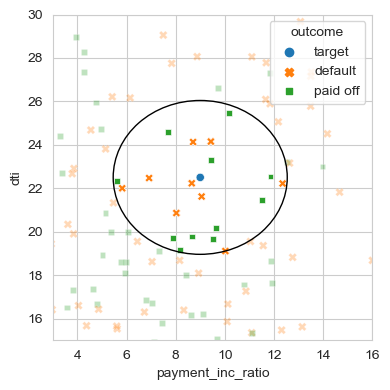

In [366]:
nbrs = knn.kneighbors(newloan)  # get the 20 neighbors [[[distance ascending]],[[corresponding index]]] 2 2D ndarrays
maxDistance = np.max(nbrs[0][0]) # np.max() to get maximum distance in sorted distance 2D ndarray

fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(data=loan200, x='payment_inc_ratio', y='dti', 
                style='outcome', hue='outcome',alpha=0.3, ax=ax)

sns.scatterplot(data=pd.concat([loan200.loc[0:0,:], loan200.loc[nbrs[1][0] + 1,:]]), # idx 0 in X is idx 1 in loan200
                x= 'payment_inc_ratio', y='dti', style='outcome', hue='outcome', ax=ax, legend=False) 

ellipse = Ellipse(xy=newloan.values[0], width= 2* maxDistance, height= 2 * maxDistance, 
                  edgecolor='black', fc='None', lw=1) # ellipse centered on newloan, diameter maxDistance 

ax.add_patch(ellipse)
ax.set_xlim(3,16)
ax.set_ylim(15,30)

plt.tight_layout()

<b><h4>Distance Metrics</h4></b>

Similarity (nearness) is determined using a distance metric, which is a function that measures how far two records ($x_1, x_2, ..., x_p$) and ($u_1, u_2, ... , u_p$) are from one another. The most popular distance metric between two vectors is <em>Euclidean distance</em>. To measure the Euclidean distance between two vectors, subtract one from the other, square the differences, sum them, and take the square root:

$\sqrt{(x_1 - u_1)^2 + (x_2 - u_2)^2 + ... + (x_p - u_p)^2}$

Another common distance metric for numeric data is <em>Manhattan distance</em>.

$|x_1 - u_1|+|x_2 - u_2|+ ... + |x_p - u_p|$

Euclidean distance corresponds to the straight-line distance between two points (eg as the crow flies). Manhattan distance is a useful approximation if similarity is defined as point to point travel time. In measuring distance between two vectors, variables (features) that are measured with a comparatively large scale will dominate the measure. For example, for the loan data, the distance would be almost solely a function of the income and loan amount variables, which are measured in tens or hundreds of thousands. Ratio variables would count for practically nothing in comparison.

There are numerous other metrics for measuring distance between vectors. For numeric data, <em>Mahalanobis</em> distance is attractive since it accounts for the correlation between two variables. This is useful since if two variables are highly correlated, Mahalanobis will essentially treat these as a single variable in terms of distance. Euclidean and Manhattan distance do not account for correlation, effectively placing greater weight on the attribute that underlies those features. Mahalanobis distance is the Euclidean distance between the principal components. The downside of using Mahalanobis distance is increased computational effort and complexity; it is computed using the covariance matrix.

<b><h4>One Hot Encoder</h4></b>

The loan data includes several factor (string) variables. Most statistical and machine learning models require this type of variable to be converted to a series of binary dummy variables conveying the same information. Instead of a single variable denoting the home occupant status as "owns with a mortgage", "owns with no mortgage", "rents" or "other", we end up with four binary variables. The first would be "owns with a mortagae - Y/N", the second would be "owns with no mortgage - Y/N", and so on. This one predictor, home occupant status, thus yields a vector with one 1 and three 0s that can be used in statistical and machine learning algorithms. The phrase one hot encoding comes from digital circuit terminology, where it describes circuit settings in which only one bit is allowed to be positive (hot).
In linear and logistic regression, one hot encoding causes problems with multicollinearity. In such cases, one dummy is omitted (its value can be inferred from the other values). This is not an issue with KNN and other methods.

<b><h4>Standardization (Normalization, z-Scores)</h4></b>

In measurement, we are often not so much interested in "how much" but in "how different from the average". Standardization, also called <em>normalization</em>, puts all variables on similar scales by subtracting the mean and dividing by the standard deviation; in this way, we ensure that a variable does not overly influence a model simply due to the scale of its original measurement:

$z = \dfrac{x-\bar x}{s}$

The result of this transformation is commonly referred to as a z-score. Measurements are then stated in terms of "standard deviations away from the mean".

For KNN and a few other procedures (eg principal component analysis and clustering), it is essential to consider standardizing the data prior to applying the procedure. 

In [367]:
loan_data = pd.read_csv('../data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], categories=['paid off', 'default'], ordered=True)
loan_data.head()

,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [368]:
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'

newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

knn = KNeighborsClassifier(n_neighbors=5) # initialize, 5 neighbors
knn.fit(X,y)   # memorize

nbrs = knn.kneighbors(newloan)
X.iloc[nbrs[1][0], :] # nbrs[1][0] idx array of closest neighbors

,payment_inc_ratio,dti,revol_bal,revol_util
35536,1.47212,1.46,1686,10.0
33651,3.38178,6.37,1688,8.4
25863,2.36303,1.39,1691,3.5
42953,1.28160,7.14,1684,3.9
43599,4.12244,8.98,1684,7.2


In [369]:
newloan

,payment_inc_ratio,dti,revol_bal,revol_util
0,2.3932,1.0,1687,9.4


Because the data is not standardized, it is clear that the revol_bar dominates the nearest neighbor comparison. The value of revol_bar in the neighbors is very close to its value in the new record, but the other predictor variables are all over the map and essentially play no role in determining the neighbors.

Next we standardize the data below before the KNN model.

In [370]:
newloan = loan_data.loc[0:0, predictors]
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

scaler = preprocessing.StandardScaler()
scaler.fit(X)

X_std = scaler.transform(X)
newloan_std = scaler.transform(newloan)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

nbrs = knn.kneighbors(newloan_std)
X.iloc[nbrs[1][0], :]


,payment_inc_ratio,dti,revol_bal,revol_util
2080,2.61091,1.03,1218,9.7
1438,2.34343,0.51,278,9.9
30215,2.71200,1.34,1075,8.5
28542,2.39760,0.74,2917,7.4
44737,2.34309,1.37,488,7.2


In [371]:
newloan

,payment_inc_ratio,dti,revol_bal,revol_util
0,2.3932,1.0,1687,9.4


The five nearest neighbors are much more alike in all the variables, providing a more sensible result. Note that the results are displayed on the original scale, but KNN was applied to the scaled data and the new loan to be predicted.

Using the z-score is just one way to rescale variables. Instead of the mean, a more robust estimate of location could be used, such as the median. Likewise, a different estimate of scale such as the interquartile range could be used instead of the standard deviation. Sometimes, variables are "squashed" into the 0-1 range. It's also important to realize that scaling each variable to have unit variance is somewhat arbitrary. This implies that each variable is thought to have the same importance in predictive power. If you have subjective knowledge that some variables are more important than others, then these could be scaled up. For example, with the loan data, it is reasonable to expect that the payment-to-income ratio is very important. Normalization (standardization) does not change the distributional shape of the data; it does not make it normally shaped if it was not already shaped.

<b><h4>Choosing K</h4></b>

The choice of K is very important to the performance of KNN. The simplest choice is to set K = 1, known as 1-nearest neighbor classifier. The prediction is intuitive: it is based on finding the data record in the training set most similar to the new record to be predicted. Setting K=1 is rarely the best choice; you will almost always obtain superior performance by using K > 1-nearest neighbors.

Generally speaking, if K is too low, we may be overfitting: including the noise in the data. Higher values of K provide smoothing that reduces the risk of overfitting in the training data. On the other hand, if K is too high, we may oversmooth the data and miss out on KNN's ability to capture the local structure in the data (underfitting), one of its main advantages.

The K that best balances between overfitting and oversmoothing is typically determined by accuracy metrics and, in particular, accuracy with holdout or validation data. There is no general rule about the best K - it depends greatly on the nature of the data. For highly structured data with little noise, smaller values of K work best. This type of data is sometimes referred to as having a high signal-to-noise ration (SNR). Examples of data with a typically high SNR are data sets for handwriting and speeach recognition. For noisy data with less structure (data with low SNR), such as the loan data, larger values of K are appropriate. Typically, values of K fall in the range 1 to 20. Often, an odd number is chosen to avoid ties.

<b><h4>Bias-Variance Trade-off</h4></b>

The tension between oversmoothing and overfitting is an instance of the bias-variance trade-off, a ubiquitous problem in statistical model fitting. Variance refers to the modeling error that occurs because of the choice of training data; that is, if you were to choose a different set of training data, the resulting model would be different. Bias refers to the modeling error that occurs because you have not properly identified the underlying real-world scenario' this error would not disappear if you simply added more training data. When a flexible model is overfit, the variance increases. You can reduce this by using a simpler model, but the bias may increase due to the loss of flexibility in modeling the real underlying situation. A general approach to handling this trade-off is through cross-validation.

<b><h4>KNN as a Feature Engine</h4></b>

KNN gained its popularity due to its simplicity and intuitive nature. In terms of performance, KNN by itself is usually not competitive with more sophisticated classification techniques. In practical model fitting, however, KNN can be used too add "local knowledge" in a staged process with other classification techniques:

1. KNN is run on the data, and for each record, a classification (or quasi-probability of a class is derived).

2. That result is added as a new feature to the record, and another classification method is then run on the data. The original predictor variables are thus used twice.

At first you might wonder whether this process, since it uses some predictors twice, causes a problem with multicollinearity. This is not an issue, since the information being incorporated into the second-stage model is highly local, derived only from a few nearby records, and is therefore additional information and not redundant.

You can think of this staged use of KNN as a form of ensemble learning, in which multiple predictive modeling methods are used in conjunction with one another. It can also be considered as a form of feature engineering in which the aim is to derive features (predictor variables) that have predictive power. Often this involves some manual review of the data; KNN gives a fairly automati way to do this.

For example, in pricing a home for sale, a realtor will base the price on similar homes recently sold, known as "comps". In essence, realtors are doing a manual version of KNN: by looking at the sale prices of similar homes, they can estimate what a home will sell for. For our example housing data, we can create a new feature for a statistical model to mimic the real estate professional by applying KNN to recent sales. The predicted value is the sales price, and the existing predictor variables could include location, total square feet, type of structure, lot size, and number of bedrooms and bathrooms. The new predictor variable (feature) that we add via KNN is the KNN predictor for each record (analogous to the realtors' comps). 

Since we are predicting a numerical value, the average of the K-Nearest Neighbos is used instead of a majority vote (known as KNN regression). Similarly, for the loan data, we can create features that represent different aspects of the loan process. Below, we build a KNN using a subset of the features and we predict the probability of a default and this probability becomes our the newest feature to add to our dataset based on credit history. Hmm, any data leakage concerns?

In [372]:
loan_data = pd.read_csv('../data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                       ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'

X = loan_data[predictors]
y = loan_data[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X,y)

loan_data['borrower_score'] = knn.predict_proba(X)[:,1] # classes are 'p


<b><h3>Tree Models</h3></b>

Tree models, also called Classification and Regression Trees (CART), decision trees or just trees, are an effective and popular classification (and regression) method. Tree models, and their more powerful descendants random forests and boosted trees, form the basis for the most widely used and powerful predictive modeling tools in data science for regression and classification.

A tree model is a set of "if-then-else" rules that are easy to understand and to implement. In contrast to linear and logistic regression, trees have the ability to discover hidden patterns corresponding to complex interactions in the data. However, unlike KNN or Naive Bayes, simple tree models can be expressed in terms of predictor relationships that are easily interpretable.

The term decision trees has a different (and older) meaning in decision science and operations research, where it refers to a human decision analysis process. In this meaning, decision points, possible outcomes, and their estimated probabilities are laid out in a braching diagram, and the decision path with the maximum expected value is chosen.

The sklearn.tree.DecisionTreeClassifier provides an implementation of a decison tree. The dmba package provides a convenience function to create a visualization inside a Jupyter notebook.

[Text(0.5, 0.875, 'x[0] <= 0.575\nentropy = 0.999\nsamples = 3000\nvalue = [1445, 1555]'),
 Text(0.2, 0.625, 'x[0] <= 0.325\nentropy = 0.99\nsamples = 2122\nvalue = [1184, 938]'),
 Text(0.1, 0.375, 'entropy = 0.751\nsamples = 265\nvalue = [208, 57]'),
 Text(0.3, 0.375, 'x[1] <= 10.423\nentropy = 0.998\nsamples = 1857\nvalue = [976, 881]'),
 Text(0.2, 0.125, 'entropy = 1.0\nsamples = 1294\nvalue = [631, 663]'),
 Text(0.4, 0.125, 'entropy = 0.963\nsamples = 563\nvalue = [345, 218]'),
 Text(0.8, 0.625, 'x[1] <= 9.191\nentropy = 0.878\nsamples = 878\nvalue = [261, 617]'),
 Text(0.7, 0.375, 'x[0] <= 0.725\nentropy = 0.766\nsamples = 600\nvalue = [134, 466]'),
 Text(0.6, 0.125, 'entropy = 0.807\nsamples = 518\nvalue = [128, 390]'),
 Text(0.8, 0.125, 'entropy = 0.378\nsamples = 82\nvalue = [6, 76]'),
 Text(0.9, 0.375, 'entropy = 0.995\nsamples = 278\nvalue = [127, 151]')]

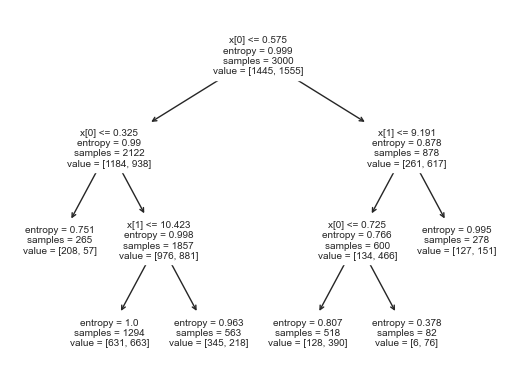

In [373]:
from sklearn import tree
from sklearn.tree import export_graphviz



loan3000 = pd.read_csv('../data/loan3000.csv')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', min_impurity_decrease=0.003)
loan_tree.fit(X, y)

tree.plot_tree(loan_tree)



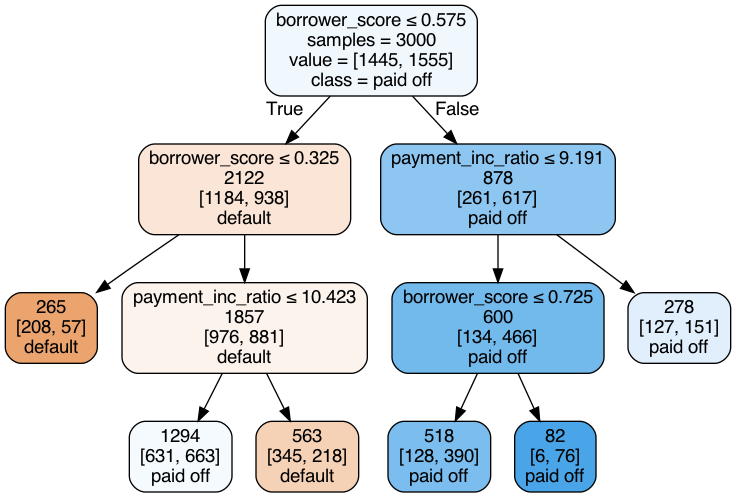

In [374]:
plotDecisionTree(loan_tree, feature_names=predictors, class_names=loan_tree.classes_)


The classification rules are determined by traversing through a hierarchical tree, starting at the root and moving left if the node is true and right if not, until a leaf is reached. Each node corresponds to a provisional classification determined by the prevalent outcome in that partition. The "loss" is the number of misclassifications yielded by the provisional classification in a partition. The values in the parentheses correspond to the number of records that are paid off or in default, respectively. The scikit-learn documentation describes how to create a text representation of a decision tree model; this can also be done with the textDecisionTree() function in the dmba package.

In [375]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


<b><h4>The Recursive Partitioning Algorithm</h4></b>

The algorithm to construct a decision tree, called recursive partitioning, is straightforward and intuitive. The data is repeatedly partitioned using predictor values that do the best job of separating the data into relatively homogeneous partitions. Suppose, we have a response variable Y and a set of P predictor variables $X_j$ for j = 1,..., P. For a partition A of records, recursive partitioning will find the best way to partition A into two subpartitions:

1. For each predictor variable $X_j$:
    1. For each value $s_j$ of $X_j$:
        1. Split the records in A with $X_j$ values < $s_j$ as one partition, and the remaining records where $X_j \geq s_j$
        2. Measure the homogeneity of classes within each subpartition of A.
    2. Select the variable $X_j$ and split value $s_j$ that produces maximum within-partition homgeneity of class.

Now comes the recursive part:
1. Initialize A with the entire data set.
2. Apply the partitioning algorithm to split A into two subpartitions, $A_1$ and $A_2$.
3. Repeat step 2 on subpartitions $A_1$ and $A_2$.
4. The algorithm terminates when no further partition can be made that sufficiently improves the homogeneity of the partitions.

The end result is a partitioning of the data, in P dimensions, with each partition predicting an outcome of 0 or 1 depending on the majority vote of the response in that partition. In addition to a binary 0/1 prediction, tree models can produce a probability estimate based on the number of 0s and 1s in the partition. The estimate is simply the sum of 0s or 1s in the partition divided by the number of observations in the partition:

$Prob(Y=1)=\dfrac{Number\;of\;1s\;in\;the\;partition}{Size\;of\;the\;partition}$

The estimated $Prob(Y=1)$ can then be converted to a binary decision; for example, set the estimate to 1 if Prob(Y=1) > 0.5.

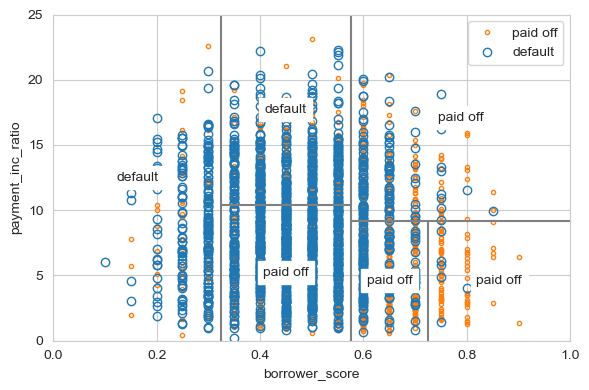

In [376]:
fig, ax = plt.subplots(figsize=(6,4))

loan3000[loan3000.outcome == 'paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none',  markeredgecolor='C1', ax=ax)

loan3000[loan3000.outcome == 'default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none',  markeredgecolor='C0', ax=ax)

ax.legend(['paid off', 'default'])
ax.set_xlim(0,1)
ax.set_ylim(0,25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

x0 = 0.575
x1a = 0.325 ; y1b = 9.191
y2a = 10.423 ; x2b = 0.725
ax.plot((x0,x0), (0,25), color='grey')
ax.plot((x1a,x1a), (0,25), color='grey')
ax.plot((x0,1), (y1b,y1b), color='grey')
ax.plot((x1a,x0), (y2a,y2a), color='grey')
ax.plot((x2b,x2b), (0,y1b), color='grey')

labels = [('default', (x1a / 2, 25 / 2)),
          ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),
          ('paid off', ((x0 + x1a) / 2, y2a / 2)),
          ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),
          ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),
          ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),
         ]
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor':'white'},
            verticalalignment='center', horizontalalignment='center')

plt.tight_layout()




<b><h4>Measuring Homogeneity or Impurity</h4></b>

Tree models recursively create partitions (sets of records), A, that predict an outcome of Y=0 or Y=1. You can see from the preceding algorithm that we need a way to measure homogeneity, also called class purity, within a partition. Or equivalently, we need to measure the impurity of a partition. The accuracy of the predictions is the proportion $p$ of misclassified records within that partition, which ranges from 0 (perfect) to 0.5 (purely random guessing).

It turns out that accuracy is not a good measure for impurity. Instead, two common measures for impurity are the Gini impurity and entropy of information. While these (and other) impurity measures apply to classification problems with more than two classes, we focus on the binary case. 

The Gini impurity for a set of records A is:

$I(A)=p(1-p)$

The entropy measure is given by:

$I(A) =  - p log_2(p) - (1-p)log_2(1-p)$

The impurity metric is used in the splitting algorithm. For each proposed partition of the data, impurity is measured for each of the partitions that results form the split. A weighted average is then calculated, and whichever partition (at each stage) yields the lowest weighted average is selected.

In [377]:
def giniFunction(x):
    return x * (1-x)


def entropyFunction(x):
    if x == 0: 
        return x
    return -x* math.log(x,2) - (1-x)*math.log(1-x,2)

<Axes: xlabel='x'>

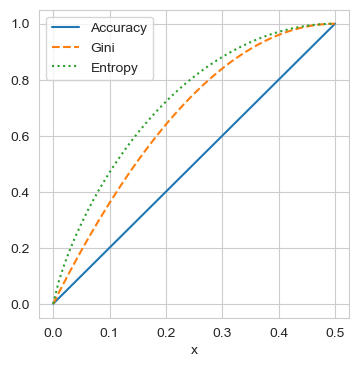

In [378]:
x = np.linspace(0, 0.5, 50)

impure = pd.DataFrame({
    'x':x,
    'Accuracy': 2*x, # since x varies from 0 (perfect) to 0.5 (random guessing)
    'Gini':[giniFunction(xi) / giniFunction(0.5) for xi in x],
    'Entropy': [entropyFunction(xi) for xi in x]
})

fig, ax = plt.subplots(figsize=(4,4))

impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')
impure.plot(x='x', y='Gini', ax=ax, linestyle='--')
impure.plot(x='x', y='Entropy', ax=ax, linestyle=':')

<b><h4>Stopping the Tree from Growing</h4></b>

As the tree grows bigger, the splitting rules become more detailed, and the tree gradually shifts from identifying "big" rules that identify real and reliable relationships in the data to "tiny" rules that reflect only noise. A fully grown tree results in completely pure leaves and, hence, 100% accuracy in classifying the data it is trained on. This accuracy, is of course, illusory - we have overfit the data, fitting the noise in the training data, not the signal that we want to identify in new data.

We need some way to determine when to stop growing a tree at a stage that will generalize to new data. There are several ways to stop splitting in Python:

- Avoid splitting a partition if a resulting subpartition is too small, or if a terminal leaf is too small. In Python's DecisionTreeClassifier(), we can control this using the parameters min_samples_split and min_samples_leaf.

- Don't split a partition if the new partition does not "significantly" reduce the impurity. In Python's DecisionTreeClassifier(), this is controlled using min_impurity_decrease, which limits splitting based on a weighted impurity decrease value. Here, smaller values will lead to more complex trees.

These methods involve aribitrary rules and can be useful for exploratory work, but we can't easily determine optimum values (ie values that maximize predictive accuracy with new data). We need to combine cross-validation with either systematically changing the model parameters or modifying the tree through pruning. In Python we can use grid search over combinations of different parameter values. For example, we can vary max_depth in the range 5 to 39 and min_ssamples_split between 20 and 100. The GridSearchCV() method in scikit-learn is a convenient way to combine the exhaustive search through all combinations with cross-validation. An optimal parameter set is then selected using the cross-validated model performance.

<b><h4>Predicting a Continuous Value</h4></b>

Predicting a continuous value (also termed regression) with a tree follows the same logic and procedure, except that impurity is measured by squared deviations from the mean in each subpartition, and predictive performance is judged by the square root of the mean squared error (RMSE) in each partition. scikit-learn has the sklearn.tree.DecisionTreeRegressor method to train a decision tree regression model.

<b><h4>How Trees Are Used</h4></b>

One of the big obstacles faced by predictive modelers in organizations is the perceived "black box" nature of the methods they use, which gives rise to opposition from other elements of the organization. In this regard, the tree model has two appealing aspects:

- Tree models provide a visual tool for exploring the data, to gain an idea of what variables are important and how they related to one another. Trees can capture nonlinear relationships among predictor variables.

- Tree models provide a set of rules that can be effectively communicated to nonspecialists, either for implementation or to "sell" a data mining project.

When it comes to prediction, however, harnessing the results from multiple trees is typically more powerful than using a single tree. In particular random forest and boosted tree algorithms almost always provide superior predictive accuracy and performance, but the aforementioned advantages of a single tree are lost.

<b><h4>Key Ideas</h4></b>

- Decision trees produce a set of rules to classify or predict an outcome.
- The rules correspond to successive partitioning of the data into subpartitions.
- Each partition, or split. references a specific value of a predictor variable and divides the data into records where that predictor value is above or below that split value.
- At each stage, the tree algorithm chooses the split that minimizes the outcome impurity within each subpartition.
- When no further splits can be made, the tree is fully grown and each terminal node, or leaf, has records of a single clas; new cases following that rule (split) path would be assigned that class.
- A fully grown tree overfits the data and must be pruned back so that it captures signal and not noise.
- Multiple-tree algorithms like random forests and boosted trees yield better predictive performance, but they lost the rule-based communicative power of single trees.

<b><h3>Bagging and the Random Forest</h3></b>

Averaging or taking majority votes of multiple models - an ensemble of models - turns out to be more accurate than just selecting one model. The simple version of ensembles is as follows:
1. Develop a predictive model and record the predictions for a given data set.
2. Repeat for multiple models on the same data.
3. For each record to be predicted, take an average (or a weighted average, or a majority vote) of their predictions.

Ensemble methods have been applied most systematically and effectively to decision trees. Ensemble tree models are so powerful that they provide a way to build good predictive models with relatively little effort. Going beyond the simple ensemble algorithm, there are two main variants of ensemble models: bagging and boosting. In the case of ensemble tree models, these are referred to as random forest models and boosted tree models.

<b><h4>Bagging</h4></b>

Bagging, stands for "bootstrap aggregating". Suppose we have a response $Y$ and $P$ predictor variables $X=X_1,X_2,...,X_p$ with N records. Bagging is like the basic algorithm for ensembles, except that, instead of fitting the various models to the same data, each new model is fitted to a bootstrap resample. Here is the algorithm :
1. Initialize $M$, the number of models to be fit, and $n$, the number of records to choose $(n<N)$. Set the iteration $m=1$.
2. Take a bootstrap resample (ie with replacement) of n records from the training data to form a subsample $Y_m$ and $X_m$ (the bag).
3. Train a model using $Y_m$ and $X_m$ to create a set of decision rules $\hat f_m(X)$.
4. Increment the model counter $m=m+1$. If $m\leq M$, go to step 2.

In the case where $\hat f_m$ predicts the probability $Y=1$, the bagged estimate is given by:

$\hat f = \dfrac{1}{M}(\hat f_1(X) + \hat f_2(X) + ... + \hat f_M(X))$

<b><h4>Random Forest</h4></b>

The <em>random forest</em> is based on applying bagging to decision trees, with one important extension : in addition to sampling the records, the algorithm also samples the variables. In traditional decison trees, to determine how to create a subpartition of a partition A, the algorithm makes the choice of variable and split point by minimizing a criterion such as Gini impurity. With random forests, at each stage of the algorithm, the choice of variable is limited to a <em>random subset of variables</em>. Compared to the basic tree algorithm, the random forest algorithm adds two more steps: the bagging and the bootstrap sampling of variables at each split:

1. Take a bootstrap (with replacement) subsample from the records.
2. For the first split, sample $p \lt P$ variables at random without replacement.
3. For each of the sampled variables $X_{j(1)}, X_{j(2)}, ..., X_{j(p)}$, apply the splitting algorithm:
    1. For each value $s_{j(k)}$ of $X_{j(k)}$:
        1. Split the records in partition A, with $X_{j(k)} \lt s_{j(k)}$ as one partition and the remaining records where $X_{j(k)} \geq s_{j(k)}$ as another partition.
        2. Measure the homogeneity of classes within each subpartition of A.
    2. Select the value of $s_j(k)$ that produces maximum within-partition homogeneity of class.
4. Select the variable $X_j(k)$ (feature) and the split value $s_j(k)$ (value of feature) that produces maximum within-partition homogeneity of class.
5. Proceed to the next split and repat the previous steps, starting from step 2.
6. Continue with additional splits, following the same procedure until the tree is grown.
7. Go back to step 1, take another bootstrap subsample, and start the process over again.

How many variables to sample at each step? A rule of thumb is to choose $\sqrt P$ where $P$ is the number of predictor variables.  In Python, we use the method sklearn.ensemble.RandomForestClassifier. By default, 500 trees are trained, we can set this value via the n_estimators keyword. 

In [379]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

rf = RandomForestClassifier(n_estimators=500, random_state=1, oob_score=True)
rf.fit(X,y)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1)

The out-of-bag (OOB) estimate of error is the error rate for the trained models, applied to the data left out of the training set for that tree.  For any $z_i=(x_i,y_i)$, is the average error calculated using predictions from the trees that do not contain $z_i$ in their respective bootstrap sample. This allows RandomForestClassifier to be fit and validated whilst being trained. 

The RandomForestClassifier implementation has no easy way to get out-of-bag estimates as a function of number of trees in the random forest. We can train a sequence of classifiers with an increasing number of trees and keep track of the  oob_score_values. This method is, however, not efficient. The resulting plot allows a practitioner to approximate a suitable value of n_estimators at which the error stabilizes.

<Axes: xlabel='n'>

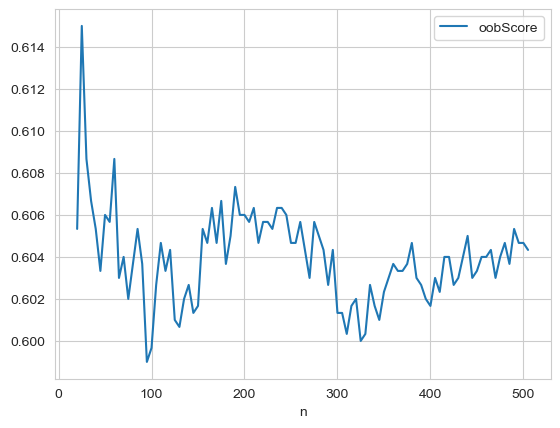

In [380]:
n_estimator = range(20,510, 5)
oobScores = []
for n in n_estimator:
    rf = RandomForestClassifier(n_estimators=n, criterion='entropy', max_depth=8, random_state=1, oob_score=True)
    rf.fit(X,y)
    oobScores.append(rf.oob_score_)

df = pd.DataFrame({'n': n_estimator, 'oobScore': oobScores})
df.plot(x='n', y='oobScore')

In [381]:
predictions = X.copy()
predictions['prediction'] = rf.predict(X)
predictions.head()

,borrower_score,payment_inc_ratio,prediction
0,0.40,5.11135,default
1,0.40,5.43165,default
2,0.70,9.23003,paid off
3,0.40,2.33482,paid off
4,0.45,12.10320,default


Text(0, 0.5, 'payment_inc_ratio')

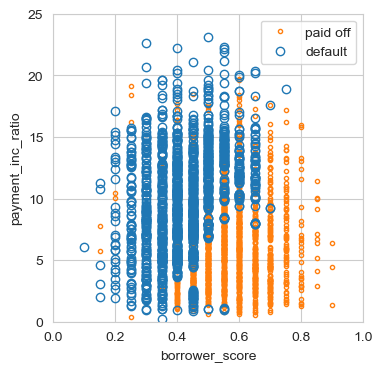

In [382]:
fig, ax = plt.subplots(figsize=(4,4))

predictions.loc[predictions.prediction == 'paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax)

predictions.loc[predictions.prediction == 'default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax)

ax.legend(['paid off', 'default'])
ax.set_xlim(0,1)
ax.set_ylim(0,25)
ax.set_xlabel('borrower_score')
ax.set_ylabel('payment_inc_ratio')

The random forest method is a "black box" method. It produces more accurate predictions than a simple tree, but the simple tree's intuitive decision rules are lost. The random forest predictions are also somewhat noisy: note that some borrower's with very high score, indicating creditworthiness, still end up with a prediction of default. This is a result of some unusual records in the data and demonstrates the danger of overfitting by the random forest.

<b><h4>Variable Importance</h4></b>

The power of the random forest algorithm shows itself when you build predictive models for data with many features and records. It has the ability to automatically determine which predictors are important and discover complex relationships between predictors corresponding to interaction terms.

In Python, the RandomForestClassifier collects information about feature importance during training and makes it available with the field feature_importances_. The "Gini decrease" is available as the feature_importances_ property of the fitted classifier. Accuracy decrease, however, is not available out of the box for Python. We can calculate it  (scores). This is to help us assess the relative performance of the variables (relative to permuting that variable). In other words there are two ways to measure variable importance:

- By the decrease in accuracy of the model if the values of a variable (feature) are randomly permuted (type=1). Randomly permuting the values has the effect of removing all predictive power for that variable. The accuracy is computed from the out-of-bag data (so this measure is effectively a cross-validated estimate). It makes sense to think that important variables will affect a borrower's likelihood to default if they change (eg employed or not).

- By the mean decrease in the Gini impurity score for all the nodes that were split on a variable (type=2). This measures how much including that variable improves the purity of the nodes. This measure is based on the training set and is therefore less reliable than a measure calculated on out-of-bag data.

In [383]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
y = loan_data[outcome]

rf_all = RandomForestClassifier(n_estimators=500, random_state=1)
rf_all.fit(X,y)

RandomForestClassifier(n_estimators=500, random_state=1)

In [384]:
importances = rf_all.feature_importances_

In [385]:
importances_df = pd.DataFrame({'predictor': X.columns, 'importance': importances})
importances_df = importances_df.sort_values(by='importance', ascending=False)
importances_df.head()

,predictor,importance
3,payment_inc_ratio,0.105652
2,dti,0.099327
5,revol_util,0.097770
9,grade,0.096952
4,revol_bal,0.094125


In [386]:
rf = RandomForestClassifier(n_estimators=500)
scores = defaultdict(list) # default dict assigns an empty list the first time key is added

# cross-validate the scores on a number of different random splits of the data
for _ in range(3):
    train_X, valid_X, train_y, valid_y = train_test_split(X,y,test_size=0.3) #different each time, no random_state
    rf.fit(train_X, train_y)  # fit to training data
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X)) # validation accuracy
    for column in X.columns:
        X_t = valid_X.copy()
        X_t[column] = np.random.permutation(X_t[column].values)  # permute column A/B test style; see if relationships are general enough
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t)) # score accuracy with random (chance) permute of one column
        scores[column].append((acc - shuff_acc)/acc) # percentage change in validation accuracy decrease with shuffle of column
print('Features sorted by their score: ')
print(sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()], reverse=True))


Features sorted by their score: 
[(0.076, 'borrower_score'), (0.0347, 'grade'), (0.0308, 'term_60 months'), (0.0104, 'annual_inc'), (0.0103, 'payment_inc_ratio'), (0.0049, 'dti'), (0.0027, 'open_acc'), (0.0021, 'purpose__small_business'), (0.0018, 'purpose_small_business'), (0.0009, 'purpose__debt_consolidation'), (0.0008, 'purpose_other'), (0.0007, 'emp_len__ > 1 Year'), (0.0006, 'purpose_credit_card'), (0.0001, 'purpose__major_purchase'), (0.0, 'revol_util'), (-0.0, 'purpose_house'), (-0.0, 'home__OWN'), (-0.0001, 'purpose_vacation'), (-0.0001, 'purpose__medical'), (-0.0002, 'purpose_medical'), (-0.0002, 'purpose_major_purchase'), (-0.0002, 'purpose__other'), (-0.0002, 'pub_rec_zero'), (-0.0003, 'home__RENT'), (-0.0003, 'emp_length'), (-0.0003, 'delinq_2yrs_zero'), (-0.0004, 'purpose_moving'), (-0.0005, 'purpose_wedding'), (-0.0005, 'purpose_home_improvement'), (-0.0005, 'purpose__home_improvement'), (-0.0021, 'purpose_debt_consolidation'), (-0.003, 'revol_bal'), (-0.0031, 'loan_amnt

In [387]:
scores_df = pd.DataFrame(scores.values(), columns=permIndex, index=scores.keys())
scores_df['mean'] = np.mean(scores_df, axis=1)
scores_df.sort_values(by='mean', ascending=False).head()

,Perm_1,Perm_2,Perm_3,mean
borrower_score,0.075083,0.077205,0.075774,0.076021
grade,0.040823,0.027256,0.036020,0.034700
term_60 months,0.030256,0.030148,0.032067,0.030824
annual_inc,0.007898,0.002114,0.021305,0.010439
payment_inc_ratio,0.009121,0.012682,0.009115,0.010306


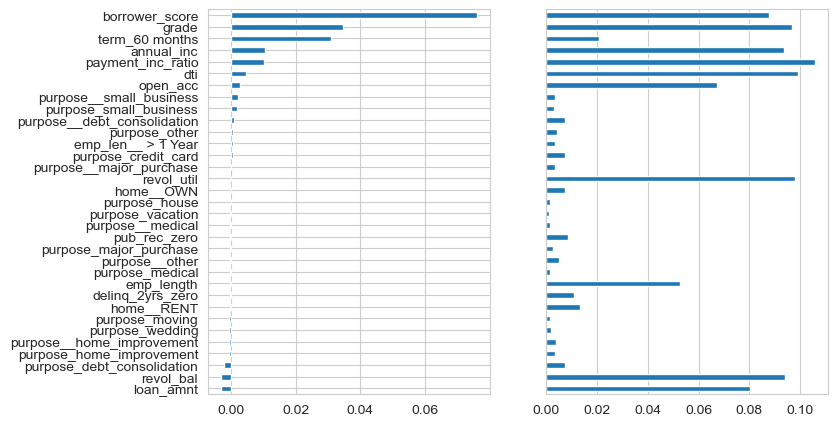

In [388]:
df = pd.DataFrame({
    'feature' : X.columns,
    'Accuracy decrease' : [np.mean(scores[column]) for column in X.columns], #scores a dict()
    'Gini decrease': rf_all.feature_importances_
})

df = df.sort_values('Accuracy decrease')

fig, axes = plt.subplots(ncols=2, figsize=(8,5))
ax = df.plot(kind='barh', x='feature', y='Accuracy decrease', legend=False, ax=axes[0])
ax.set_ylabel('')

ax = df.plot(kind='barh', x='feature', y='Gini decrease', legend=False, ax=axes[1])
ax.set_ylabel('')
ax.get_yaxis().set_visible(False) # they share the same y axis

The left and right panels of the figure above show variable importance according to the decrease in accuracy and in Gini impurity, respectively.The variables in both panels are ranked by the decrease in accuracy. The variable importance scores produced by these two measures are quite different.

Since the accuracy decrase is a more reliable metric, whicy should we use the Gini impurity decrease measure? By default, RandomForestClassifier()  (via feature_importances_) computes only this Gini impurity: Gini impurity is a byproduct of the algorithm, whereas model accuracy by variable requires extra computations (randomly permuting the data and predicting this data). In cases where computational complexity is important, such as in a production setting where thousands of models are fit, it may not be worth the extra computational effor. In addition, the Gini decrease sheds light on which variables the random forest is using to make its splitting rules (recall this is information, readily visible in a simple tree, is effectively lost in a random forest).

<b><h4>Hyperparameters</h4></b>
The random forest, as with many statistical machine learning algorithms, can be considered a black-box algorithm with knobs to adjust how the box works. These knobs are called hyperparameters, which are parameters that you need to set before fitting a model; they are not optimized as part of the training process. While traditional statistical models require choices (eg the choice of predictors to use in a regression model), the hyperparameters for random forest are more critical, especially to avoid overfitting. In particular, the two most important hyperparameters for the random forest are:

- nodesize / min_samples_leaf : The minimum size for terminal nodes (leaves in the tree). The scikit-learn implementation in Python uses a default of 1 for both classification and regression.

- maxnodes / max_leaf_nodes : The maximum number of nodes in each decision tree. By default, there is no limit and the largest tree will be fit subject to the constraint of nodesize / min_samples_leaf. In Python, you specify the maximum number of terminal nodes. The two parameters are related: $maxnodes = 2max\_leaf\_nodes - 1$

It may be tempting to ignore these parameters and simply go with the default values. However, using the defaults may lead to overfitting when you apply the random forest to noisy data. When you increase nodesize/min_samples_leaf or set maxnodes/max_leaf_nodes, the algorithm will fit smaller tress and is likey to create spurious predictive rules. Cross-validation can bbe used to test the effects of setting different values for hyperparameters.

<b><h4>Key Ideas</h4></b>

- Ensemble models improve model accuracy by combining the results from many models.
- Bagging is a particular type of ensemble model based on fitting many models to bootstrapped samples of the data and averaging the models.
- Random forest is a special type of bagging applied to decision trees. In addition to resampling the data, the random forest algorithm samples the predictor variables when splitting the trees.
- A useful output from the random forest is a measure of variable importance that ranks the predictors in terms of their contribution to model accuracy.
- The random forest has a set of hyperparameters that should be tuned using cross-validatain to avoid overfitting.

<b><h3>Boosting</h3></b>

Ensemble models have become a standard tool for predictive modeling. Boosting is a general technique to create an ensemble of models. It was developed around the same time as bagging. Like bagging, boosting is most commonly used with decision trees. Despite their similarities, boosting takes a very different approach - one that comes with more belss and whistles. As a result, while bagging can be done with relatively little tuning, boosting requries much greater care in its application. If these two methods were cars, bagging could be considered a Honda Accord (reliable and steady), whereas boosting could be considered a Porsche (powerful but requires more care).

In linear regression models, the residuals are often examined to see if the fit can be improved. Boosting takes this concept much further and fits a series of models, in which each successive model seeks to maximize the error of the previous model. Several variants of the algorithm are commonly used: Adaboost, gradient boosting, and stochastic gradient boosting. The latter, stochastic gradient boosting, is the most general and widely used. Indeed, with the right choicd of parameters, the algorithm can emulate the random forest.

In [396]:
predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
labelenc = preprocessing.LabelEncoder()
y = labelenc.fit_transform(loan3000[outcome])

xgb = XGBClassifier(objective='binary:logistic', subsample=.63, use_label_encoder=False, eval_metric='error')
print(xgb.fit(X, y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [397]:
xgb.classes_

array([0, 1])

In [398]:
labelenc.classes_

array(['default', 'paid off'], dtype=object)

In [400]:
labelenc.transform(['default'])

array([0])

In [401]:
xgb_df = X.copy()
xgb_df['prediction'] = labelenc.inverse_transform(xgb.predict(X))
xgb_df['prob_default'] = xgb.predict_proba(X)[:,0]  # default is class 0
xgb_df.head()

,borrower_score,payment_inc_ratio,prediction,prob_default
0,0.40,5.11135,paid off,0.171144
1,0.40,5.43165,default,0.739844
2,0.70,9.23003,default,0.679195
3,0.40,2.33482,paid off,0.321995
4,0.45,12.10320,default,0.859796


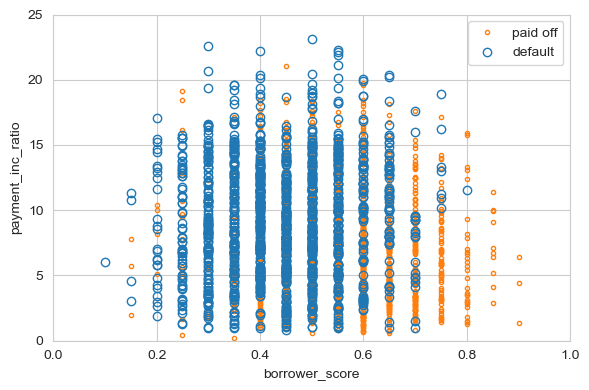

In [402]:
fig, ax = plt.subplots(figsize=(6,4))

xgb_df.loc[xgb_df.prediction == 'paid off'].plot(
    x='borrower_score', y='payment_inc_ratio', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax, label='paid off')

xgb_df.loc[xgb_df.prediction == 'default'].plot(
    x='borrower_score', y='payment_inc_ratio', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax, label='default')

ax.set_xlim(0,1)
ax.set_ylim(0,25)
ax.set_ylabel('payment_inc_ratio')
ax.set_xlabel('borrower_score')

plt.tight_layout()


<b><h4>Regularization: Avoiding Overfitting</h4></b>

Blind application of xgboost can lead to unstable models as a result of overfitting to the training data. The problem with overfitting is twofold:
- The accuracy of the model on new data not in the training set will be degraded.
- The predictions from the model are highly variable, leading to unstable results.

Any modeling technique is potentially prone to overfitting. For example, if too many variables are included in a regression equation, the model may end up with spurious predictions. However, for most statistical techniques, overfittiing can be avoided by judicious selection of predictor variables. Even the random forest generally produces a reasonable model without tuning the parameters. This however is not the case for xgboost.

In [407]:
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti', 
              'payment_inc_ratio', 'revol_bal', 'revol_util', 
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero', 
              'open_acc', 'grade', 'emp_length', 'purpose_', 
              'home_', 'emp_len_', 'borrower_score']
outcome = 'outcome'

X = pd.get_dummies(loan_data[predictors], drop_first=True)
labelenc = preprocessing.LabelEncoder()
y = labelenc.fit_transform(loan_data[outcome])

train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=10000)

xgb_default = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6, reg_lambda=0,
                            learning_rate=0.3, subsample=1)

print(xgb_default.fit(train_X, train_y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [395]:
xgb_default.classes_

array([0, 1])

In [404]:
labelenc.classes_

array(['default', 'paid off'], dtype=object)

In [405]:
labelenc.transform(['paid off'])

array([1])

In [450]:
train_default = xgb_default.predict_proba(train_X)[:,0]
error_default = abs(train_default - train_y) < 0.5 # misclassified labels, using default (class 0)
np.mean(error_default)

0.12220587403089808

In [455]:
train_paid_off = xgb_default.predict_proba(train_X)[:,1]
error_paid_off = abs(train_paid_off - train_y) > 0.5 # misclassified labels, using default (class 1)
np.mean(error_paid_off)

0.12220587403089808

In [436]:
valid_default = xgb_default.predict_proba(valid_X)[:, 0]
error_default = abs(valid_default- valid_y ) < 0.5 # for class 0, wrong predictions will have errors less than 0.5
print('default: ', np.mean(error_default))

default:  0.36


In [456]:
""" Error rate calculation using class 0 or class 1 via deviation.

For class 0 or 1, an error is when the actual label is class 0 or 1 respectively, but the probability assigned 
that class by the model is less than 0.5. For class 0, this means the absolute deviation of the assigned 
probability from 0,the class label, for a misclassified label will be less than 0.5 eg abs(0-0.4) = 0.4. For 
class 1, this means that the absolute deviation of the assigned probability from 1, the class label, will be 
greater than 0.5 eg. abs(1-0.4) = 0.6. Thus we can use either class 0 or 1 to determine the error rate.

"""
pd.DataFrame({'original': labelenc.inverse_transform(train_y), 
            'train_y': train_y,
            'prediction': labelenc.inverse_transform(xgb_default.predict(train_X)),
            'proba_default': xgb_default.predict_proba(train_X)[:,0], # class 0
            'proba_paid_off' : xgb_default.predict_proba(train_X)[:,1], # class 1
            'error_default' : abs(xgb_default.predict_proba(train_X)[:,0] - train_y) < 0.5, # error using class 0
            'error_paid_off' : abs(xgb_default.predict_proba(train_X)[:,1] - train_y) > 0.5,# error using class 1
            
}).head(10)


,original,train_y,prediction,proba_default,proba_paid_off,error_default,error_paid_off
0,default,0,default,0.984026,0.015974,False,False
1,default,0,default,0.576533,0.423467,False,False
2,default,0,default,0.931260,0.068740,False,False
3,default,0,paid off,0.483439,0.516561,True,True
4,paid off,1,paid off,0.141716,0.858284,False,False
5,default,0,default,0.683651,0.316349,False,False
6,paid off,1,default,0.552444,0.447556,True,True
7,default,0,default,0.789260,0.210740,False,False
8,default,0,default,0.824093,0.175907,False,False
9,paid off,1,paid off,0.274398,0.725602,False,False


The test set consists of 10,000 randomly sampled recoreds from the full data, and the training set consists of the remaining records. Boosting leads to an error rate of only 12.2% for the training set. The test set, however, has a much higher error rate of 36%. This is a result of overfitting: while boosting can explain the variablity in the training set very well, the prediction rules do not apply to the new data.

Boosting provides several parameters to avoid overfitting, including the parameters $\eta\;(or\;learning\_rate)$ and $subsample$. Another approach is $regularization$, a technique that modifies the cost function in order to penalize the complexity of the model. Decision trees are fit by minimizing cost criteria such as Gini's impurity score. In $xgboost$, it is possible to modify the cost function by adding a term that measures the complexity of the model. 

There are two parameters in $xgboost$ to regularize the model: $alpha$ and $lambda$, which correspond to Manhattan distance (L1-regularization) and squared Euclidean distance (L2-regularization), respectively. Increasing these parameters will penalize more complex models and reduce the size of the trees that are fit. In the scikit-learn API, the parameters are called $reg\_alpha$ and $reg\_lambda$ .Below we set lambda to 1000 for L2-regularization and alpha to 1000 for L1-regularization both reducing the test error by a smidge.

In [415]:
xgb_penalty = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_lambda=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')

print(xgb_penalty.fit(train_X,train_y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [416]:
pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 0]
error_penalty = abs(valid_y - pred_penalty) < 0.5
print('penalty: ', np.mean(error_penalty))

penalty:  0.3317


In [457]:
xgb_manhattan = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=6,
                            reg_alpha=1000, learning_rate=0.1, subsample=0.63,
                            use_label_encoder=False, eval_metric='error')

print(xgb_manhattan.fit(train_X,train_y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [458]:
pred_manh = xgb_manhattan.predict_proba(valid_X)[:, 0]
error_penalty = abs(valid_y - pred_manh) < 0.5
print('penalty: ', np.mean(error_penalty))

penalty:  0.3334


In Pythn, we can call the predict_proba method with the iteration_range argument. This forces only the first i trees to be used in prediction. This lets us directly compare the in-sample versus out-of-sample error rates as more models are added. 

We can then use the pandas plot method to create a line graph of the error versus the number of iterations. The axis returned from the first plot allows us to overlay additional lines onto the same graph. 

In [463]:
results=[]
for i in range(1,250):
    iteration_range = [1, i+1]
    train_default = xgb_default.predict_proba(train_X, iteration_range=iteration_range)[:,0]
    train_penalty = xgb_penalty.predict_proba(train_X, iteration_range=iteration_range)[:,0]
    pred_default = xgb_default.predict_proba(valid_X, iteration_range=iteration_range)[:,0]
    pred_penalty = xgb_penalty.predict_proba(valid_X, iteration_range=iteration_range)[:,0]
    results.append({
        'iterations': i,
        'default train' : np.mean(abs(train_y - train_default) < 0.5), # default is class 0
        'penalty train' : np.mean(abs(train_y - train_penalty) < 0.5),
        'default test' : np.mean(abs(valid_y - pred_default) < 0.5),
        'penalty test' : np.mean(abs(valid_y - pred_penalty) < 0.5)

    })
results = pd.DataFrame(results)
results.head()

,iterations,default train,penalty train,default test,penalty test
0,1,0.343925,0.335946,0.3518,0.3530
1,2,0.328985,0.334871,0.3474,0.3481
2,3,0.323411,0.336738,0.3440,0.3470
3,4,0.319110,0.341492,0.3442,0.3492
4,5,0.316422,0.332522,0.3420,0.3422


In [460]:
xgb_manhattan.classes_

array([0, 1])

In [465]:
labelenc.transform(['default'])

array([0])

<Axes: xlabel='iterations'>

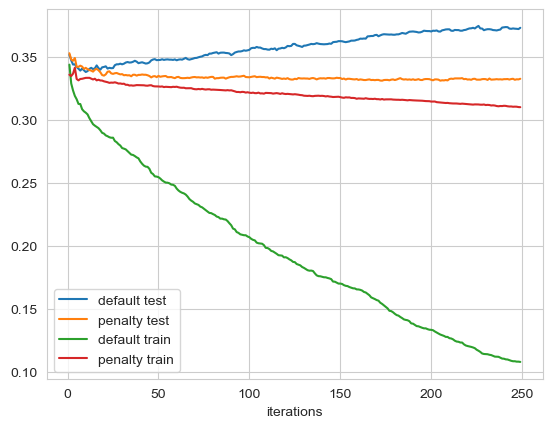

In [466]:
ax = results.plot(x='iterations', y='default test')
results.plot(x='iterations', y='penalty test', ax=ax)
results.plot(x='iterations', y='default train', ax=ax)
results.plot(x='iterations', y='penalty train', ax=ax)

The result in the plot above, shows how the default model steadily improves the accuracy for the training set but actually gets worse for the test set. The penalized model does not exhibit this behavior.

<b><h4>Ridge Regression and the Lasso</h4></b>
Adding a penalty on the complexity of a model to help avoid overfitting dates back to the 1970s. Least squares regression minimizes the residual sum of squares (RSS). Ridge regression minimizes the sum of squared residuals plus a penalty term that is a function of the number and size of the coefficients.

$\sum_{i=1}^n(Y_i - \hat b_0  - \hat b_1X_i - \hat bX_p)^2 + \lambda(\hat b_1^2 + ... + \hat b_p^2)$

The value of $\lambda$ determines how much of the coefficients are penalized; larger values produce models that are less likely to overfit the data. The $Lasso$ is similar, except that it uses Manhattan distance instead of Euclidean distance as a penalty term:

$\sum_{i=1}^n(Y_i - \hat b_0  - \hat b_1X_i - \hat bX_p)^2 + \alpha(|\hat b_1| + ... + |\hat b_p|)$

Using Euclidean distance is also known as L2 regularization, and using Manhattan distance as L1 regulatization. The xgboost parameters $reg\_lambda$ ($lambda$) and $reg\_alpha$ ($alpha$) are acting in a similar manner. 

<b><h4>Hyperparameters and Cross-Validation</h4></b>

xgboost has a daunting array of hyperparameters; the specific choice can dramatically change the model fit. Given a huge combination of hyperparameters to choose from, how should we be guided in our choice. A standard solution to this problem is to use cross-validation. Cross-validation randomly splits up the data into K different groups, also called folds. For each fold, a model is trained on the data in the fold and then evaluated on the data in the fold. This yields a measure of accuracy of the model on out-of-sample data. The best set of hyperparameters is the one given by the model with the lowest overall error as computed by averaging the errors from each of the folds.

To illustrate this technique, we apply it to parameter selection for xgboost. In this example, we explore two parameters: the shrinkage parameter $\eta\;(learning\_rate)$, and the maximum depth of trees $max\_depth$. The parameter $max\_depth$ is the maximum depth of a leaf node to the root of the tree. This gives us another way to control overfitting: deep trees tend to be more complex and may overfit the data. In Python, we create all possible combinations of hyperparameters and fit and evaluate models with each combination. We use itertools.product() from the Python standard library to create all possible combinations of the two hyperparameters.

In [471]:
idx = np.random.choice(range(5), size=len(X), replace=True) # generate data-length random values from 0-4
error = []
for eta, max_depth in product([0.1, 0.5, 0.9], [3,6,9]):
    xgb = XGBClassifier(objective='binary:logistic', n_estimators=250, max_depth=max_depth, learning_rate=eta)
    cv_error = []
    for k in range(5):                  # for each eta, max_depth we do a 5-fold cross validation
        fold_idx = idx == k             # generate mask, True if random number is current k, False if not
        train_X  = X.loc[~fold_idx]     # negate mask, rows with False in fold_idx become True; training set 
        train_y = y[~fold_idx]          
        valid_X = X.loc[fold_idx]       # use mask as is, rows with True in fold_idx
        valid_y = y[fold_idx]           

        xgb.fit(train_X, train_y)
        pred = xgb.predict_proba(valid_X)[:,0]
        cv_error.append(np.mean(abs(valid_y - pred) < 0.5))  # cross-validation error
    error.append({
        'eta' : eta,
        'max_depth' : max_depth,
        'avg_error' : np.mean(cv_error) # average cross-validation error
    })

errors = pd.DataFrame(error)

In [475]:
errors.sort_values(by='avg_error')

,eta,max_depth,avg_error
0,0.1,3,0.328660
1,0.1,6,0.337539
3,0.5,3,0.341713
2,0.1,9,0.345263
6,0.9,3,0.352698
4,0.5,6,0.365621
5,0.5,9,0.371708
8,0.9,9,0.380826
7,0.9,6,0.388580


Cross-validation suggests that using shallower trees with a smaller value of $\eta / leanring\_rate$ yields more accurate results. Since these models are alsomore stable, the best parameters to use are $\eta=0.1$ and $max\_depth=3$ (or possibly $max\_depth=6$).

In [501]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error'))

max_depth         3         6         9
eta                                    
0.1        0.328660  0.337539  0.345263
0.5        0.341713  0.365621  0.371708
0.9        0.352698  0.388580  0.380826
